### Exercise 1
#### By Cooper Nederhood

In [63]:
#import packages 
import numpy as np
import pandas as pd
import scipy.stats as sts
import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy import special
from scipy.integrate import quad

In [11]:
data = np.loadtxt('clms.txt')


#### Part a:

In [13]:
# Describe data
data_df = pd.DataFrame(data)
data_df.describe()

,0
count,10619.000000
mean,720.277975
std,3972.850824
min,0.010000
25%,74.450000
50%,172.210000
75%,451.535000
max,227967.250000


Text(0,0.5,'Percent of total obs')

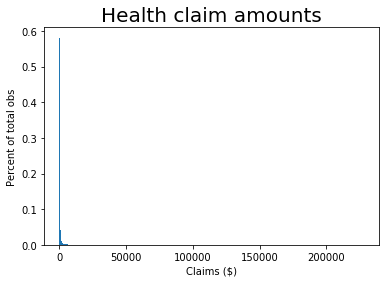

In [8]:
# Part (a):
w = (1 / data.shape[0]) * np.ones_like(data)

# Histogram 
count, bins, ignored = plt.hist(data, 1000, weights=w)
plt.title('Health claim amounts', fontsize=20)
plt.xlabel('Claims ($)')
plt.ylabel('Percent of total obs')



(0, 800)

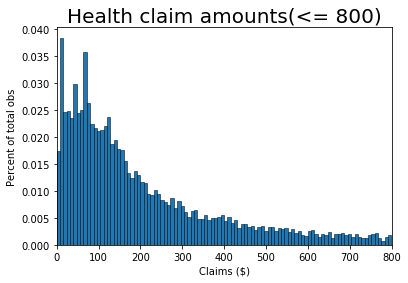

In [10]:
# Other histogram
b = data <= 800
data_subsection = data[b]
weights = (1 / data.shape[0]) * np.ones_like(data_subsection)
n, bins, ignored = plt.hist(data_subsection, 100, weights=weights, edgecolor='black',
                                linewidth=0.5)
plt.title('Health claim amounts(<= 800)', fontsize=20)
plt.xlabel('Claims ($)')
plt.ylabel('Percent of total obs')
plt.xlim(0, 800)

If we want to zoon in and see the variation within the 0-800($) claim amounts, the second histogram is better. Because this subsection has low probability compared to the whole, when included with all observations the variation within the group is hard to discern.

#### Part b (gamma):

In [19]:
# Define functions

def GA_pdf(xvals, alpha, beta):

    pdf_vals = 1/((beta ** alpha) * special.gamma(alpha)) * (xvals ** (alpha - 1)) * np.exp(-xvals/beta)
    return pdf_vals

def log_lik_GA(xvals, alpha, beta):
  
    pdf_vals = GA_pdf(xvals, alpha, beta)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def criterion_fn(params, args):
    
    alpha, beta = params
    xvals = args
    log_lik_val = log_lik_GA(xvals, alpha, beta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [ ]:
beta0 = (data.var())/data.mean()
alpha0 = data.mean()/beta0  
params0 = (alpha0, beta0)

In [22]:
bounds = ((1e-6, None), (1e-6, None))
results = opt.minimize(criterion_fn, params0, args=(data), method ='L-BFGS-B', bounds=bounds)
alpha1, beta1 = results.x
print("Estimation results are: \n", results)

Estimation results are: 
       fun: 82076.45160566256
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.        , 0.09022187])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 8
   status: 0
  success: True
        x: array([2.21755323e-01, 2.19110647e+04])


(0, 800)

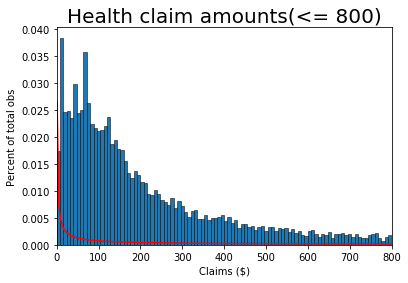

In [30]:
# Other histogram AGAIN!
b = data <= 800
data_subsection = data[b]
weights = (1 / data.shape[0]) * np.ones_like(data_subsection)
n, bins, ignored = plt.hist(data_subsection, 100, weights=weights, edgecolor='black',
                                linewidth=0.5)
plt.title('Health claim amounts(<= 800)', fontsize=20)
plt.xlabel('Claims ($)')
plt.ylabel('Percent of total obs')

x_vals = np.linspace(1, 800, 200)
plt.plot(x_vals, GA_pdf(x_vals, alpha1, beta1), label='Estimate', color='r')
plt.xlim(0, 800)

#### Part c (Generalized gamma):

In [42]:
# Define functions

def GG_pdf(xvals, alpha, beta, m):

    pdf_vals = m/((beta**alpha)*special.gamma(alpha/m))*(xvals**(alpha - 1))*np.exp(-(xvals/beta)**m)
    return pdf_vals

def log_lik_GG(xvals, alpha, beta, m):
  
    pdf_vals = GG_pdf(xvals, alpha, beta, m)
    ln_pdf_vals = np.log(pdf_vals)
     
    return ln_pdf_vals.sum()

def criterion_fnGG(params, args):
    
    alpha, beta, m = params
    xvals = args
    log_lik_val = log_lik_GG(xvals, alpha, beta, m)
    
    return -log_lik_val

In [43]:
m = 1
params1 = (alpha1, beta1, m)

bounds = ((1e-6, None), (1e-6, None), (1e-6, None))
resultGG = opt.minimize(criterion_fnGG, params1, args=(data), method ='L-BFGS-B', bounds=bounds)
alpha2, beta2, m2 = resultGG.x
print("Estimation results are: \n", resultGG)

Estimation results are: 
       fun: 82076.44679084865
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.65253072,  0.09167707, -1.04337232])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 2
   status: 0
  success: True
        x: array([2.21737619e-01, 2.19110644e+04, 9.97091566e-01])


(0, 800)

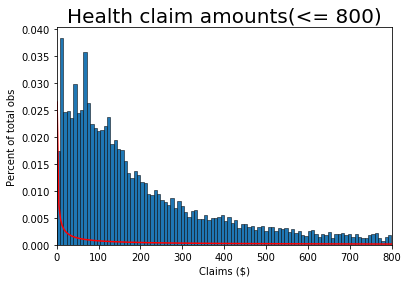

In [50]:
# Other histogram AGAIN!
b = data <= 800
data_subsection = data[b]
weights = (1 / data.shape[0]) * np.ones_like(data_subsection)
n, bins, ignored = plt.hist(data_subsection, 100, weights=weights, edgecolor='black',
                                linewidth=0.5)
plt.title('Health claim amounts(<= 800)', fontsize=20)
plt.xlabel('Claims ($)')
plt.ylabel('Percent of total obs')

x_vals = np.linspace(1, 800, 200)
plt.plot(x_vals, GG_pdf(x_vals, alpha2, beta2, m2), label='Estimate', color='r')
plt.xlim(0, 800)

#### Part d: (More generalized gamma)

In [53]:
q0 = 200
a0 = m2
b0 = q0**(1/a0)*beta2
p0 = alpha2/m2

params_GB2 = (a0, b0, p0, q0)

In [54]:
# Define functions
def GB2_pdf(xvals, a, b ,p, q):
    x = a*xvals**(a*p-1)
    y = (b**(a*p))*special.beta(p,q)*((1+(xvals/b)**a)**(p+q))
    pdf_vals = x/y
    return pdf_vals

def log_lik_GB2(xvals, a, b, p, q):
  
    pdf_vals = GB2_pdf(xvals, a, b ,p, q)
    ln_pdf_vals = np.log(pdf_vals)
     
    return ln_pdf_vals.sum()

def criterion_fnGB2(params, args):
    
    a, b, p, q = params
    xvals = args
    log_lik_val = log_lik_GB2(xvals, a, b, p, q)
    
    return -log_lik_val

In [55]:
bounds = ((1e-6, None), (1e-6, None), (1e-6, None), (1e-6, None))
resultGB2 = opt.minimize(criterion_fnGB2, params_GB2, args=(data), method ='L-BFGS-B', bounds=bounds)
a1, b1, p1, q1 = resultGB2.x
print("Estimation results are: \n", resultGB2)

Estimation results are: 
       fun: 74880.41669880107
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.20841388e+00,  1.45519152e-03, -2.12457962e-01, -2.67755240e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 610
      nit: 79
   status: 0
  success: True
        x: array([1.12630384e-01, 4.45046496e+06, 4.60353961e+01, 1.42298270e+02])


(0, 800)

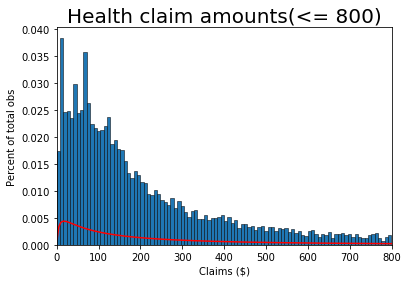

In [56]:
# Lol. Plot the same histogram again
b = data <= 800
data_subsection = data[b]
weights = (1 / data.shape[0]) * np.ones_like(data_subsection)
n, bins, ignored = plt.hist(data_subsection, 100, weights=weights, edgecolor='black',
                                linewidth=0.5)
plt.title('Health claim amounts(<= 800)', fontsize=20)
plt.xlabel('Claims ($)')
plt.ylabel('Percent of total obs')

x_vals = np.linspace(1, 800, 200)
plt.plot(x_vals, GB2_pdf(x_vals, a1, b1, p1, q1), label='Estimate', color='r')
plt.xlim(0, 800)

#### Part e: LR test

In [62]:
GB2 = log_lik_GB2(data, a1, b1, p1, q1)
GG = log_lik_GG(data, a1, b1, m)
GA = log_lik_GA(data, alpha1, beta1)
GG_val = abs(2 * (GG - GB2))
GA_val = abs(2 * (GA - GB2))
pval_GG = 1.0 - sts.chi2.cdf(GA_val, 4)
pval_GA = 1.0 - sts.chi2.cdf(GA_val, 4)
print('chi squared of H0 with 4 degrees of freedom p-value (Generalized Gamma Distribution) = ', pval_GG)
print('chi squared of H0 with 4 degrees of freedom p-value (Gamma Distribution) = ', pval_GA)

chi squared of H0 with 4 degrees of freedom p-value (Generalized Gamma Distribution) =  0.0
chi squared of H0 with 4 degrees of freedom p-value (Gamma Distribution) =  0.0
